In [1]:
using Pkg
Pkg.activate("/mnt/dv/wid/projects4/SolisLemus-network-merging/")

using InPhyNet, PhyloNetworks
base_dir = "/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/"
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/simulation-study/simulation-scripts/helpers/helpers.jl")
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/simulation-study/simulation-scripts/helpers/est_constraints-helpers.jl")

  Activating project at `/mnt/dv/wid/projects4/SolisLemus-network-merging`


log_runtime (generic function with 1 method)

#### Load and Examine Data

In [4]:
est_gts = readMultiTopology(joinpath(base_dir, "data", "Best.FAA.tre"))
length(est_gts)

410

*Lots* of spread in the estimated gene trees on who is included

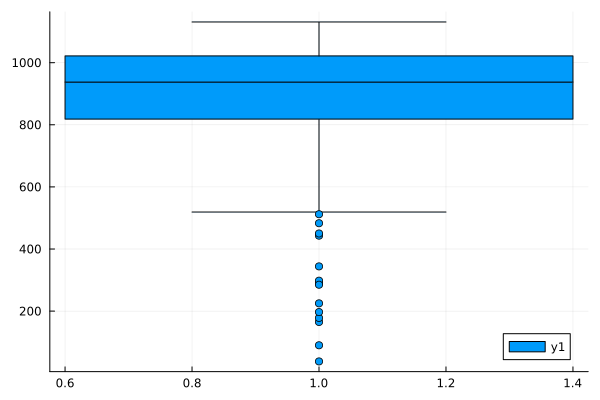

In [56]:
using Plots, StatsPlots
ntaxas = [t.numTaxa for t in est_gts]
println("min: $(minimum(ntaxas)), max: $(maximum(ntaxas))")
uq_names = Set()
for t in est_gts
    union!(uq_names, [l.name for l in t.leaf])
end
println("total unique names: $(length(uq_names))")

boxplot(ntaxas)

In [57]:
name_vec = Vector(collect(keys(uq_names.dict)))
name_map = Dict([name_vec[i] => i for i=1:length(uq_names)])
counts = zeros(length(uq_names))
for gt in est_gts
    for leaf in gt.leaf
        counts[name_map[leaf.name]] += 1
    end
end
minimum(counts), maximum(counts)

(75.0, 398.0)

## Subset decomposition

In [5]:
est_D, est_namelist = calculateAGIC(est_gts)

([0.0 23.362962962962964 … 19.582278481012658 20.869109947643977; 23.362962962962964 0.0 … 35.43092105263158 36.61423220973783; … ; 19.582278481012658 35.43092105263158 … 0.0 10.524663677130045; 20.869109947643977 36.61423220973783 … 10.524663677130045 0.0], ["AALA", "AAXJ", "ABCD", "ABEH", "ABIJ", "ABSS", "ACFP", "ACRY", "ACWS", "ADHK"  …  "ZSSR", "ZTHV", "ZTLR", "ZUHO", "ZULJ", "ZXJO", "ZYAX", "ZYCD", "ZZEI", "ZZOL"])

In [6]:
best_tree = readTopology("data/estimated_species_tree.tree")
subsets = sateIdecomp(best_tree, 25)
println(sort([length(s) for s in subsets])[1:5])
println(maximum([length(s) for s in subsets]))
println(length(subsets))

[10, 11, 11, 11, 11]
25
69


## Generate Condor data

Outline:

We use stopping rules to decide the number of retics in each subnet, so
1. if no snaq file exists yet, submit runs w/ h=0,1
2. if snaq files exist, load last 2 runs and check if another should be submitted with the function `should_stop_AIC`

This code should build the submit file's tables from scratch each time so that runs are never re-submitted.

In [7]:
df_dir = "data/CFs/"
init_dir = "data/init_trees/"
out_dir = "data/snaq_outputs/"
tab_file = "condor/inputs.tab"

open(tab_file, "a+") do tab_io
    # For now just queue all of them with h=0, 1, 2 b/c it's easier...
    for (i, subset_taxa) in enumerate(subsets)
        print("\r$(i)/$(length(subsets))")
        flush(stdout)

        temp_gts = Array{HybridNetwork}(undef, length(est_gts))
        for i = 1:length(est_gts)
            if length(intersect([l.name for l in est_gts[i].leaf], subset_taxa)) >= 4
                temp_gts[i] = pruneTruthFromDecomp(est_gts[i], subset_taxa)
            end
        end
        temp_gts = temp_gts[findall(i -> isassigned(temp_gts, i), 1:length(temp_gts))]

        # 1. count quartets
        q, t = silently() do
            countquartetsintrees([t for t in temp_gts if length(t.leaf) >= 4])
        end
        df = silently() do
            readTableCF(writeTableCF(q, t))
        end
        CSV.write(joinpath(df_dir, "df_$(i).csv"), writeTableCF(df))

        # 2. save starting tree
        init_tree = pruneTruthFromDecomp(best_tree, subset_taxa)
        writeTopology(init_tree, joinpath(init_dir, "init_$(i).tre"))

        # 3. Write info to Condor input table
        write(tab_io, "$(i),0\n")
        write(tab_io, "$(i),1\n")
        write(tab_io, "$(i),2\n")
    end
end

69/69

## Infer constraints

This is done in Condor with the submit file `empirical-study/condor/submit.submit`

## InPhyNet

In [5]:
df = readTableCF("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/CFs/df_1.csv")
tre0 = readTopology("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/init_trees/init_1.tre")
tre = readTopology("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/Best.FAA.tre")

between 43.0 and 331.0 gene trees per 4-taxon set


HybridNetwork, Rooted Network
44 edges
45 nodes: 23 tips, 0 hybrid nodes, 22 internal tree nodes.
tip labels: JSAG, XZME, LELS, VTUS, ...
(((JSAG:0.054,((XZME:0.071,((LELS:0.049,VTUS:0.04)100:0.056,MTHW:0.088)42:0.017)73:0.046,THDM:0.16)47:0.025)99:0.132,(((KYNE:0.095,((EMJJ:0.09,(((FCEL:0.042,(BLAJ:0.0,JHUL:0.0)100:0.038)49:0.006,WTDE:0.098)98:0.041,JVBR:0.085)93:0.03)56:0.014,(LTZF:0.111,SART:0.082)10:0.005)24:0.012)19:0.016,RDYY:0.047)46:0.013,YJUG:0.12)44:0.011)37:0.017,((AFLV:0.066,OOSO:0.081)48:0.011,(MWYQ:0.066,((GDKK:0.026,QNPH:0.022)100:0.075,THEW:0.111)69:0.033)53:0.027)15:0.009)22;
